In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import detrend

In [2]:
pos_df = pd.read_csv('POS_data.csv')
pos_df.head()

,units,dtdate,date,mon,yr
0,NaN,02JAN2004:08:00:00,2-Jan-04,1,2004
1,1940.0,02JAN2004:09:00:00,2-Jan-04,1,2004
2,NaN,02JAN2004:10:00:00,2-Jan-04,1,2004
3,3147.0,02JAN2004:11:00:00,2-Jan-04,1,2004
4,NaN,02JAN2004:12:00:00,2-Jan-04,1,2004


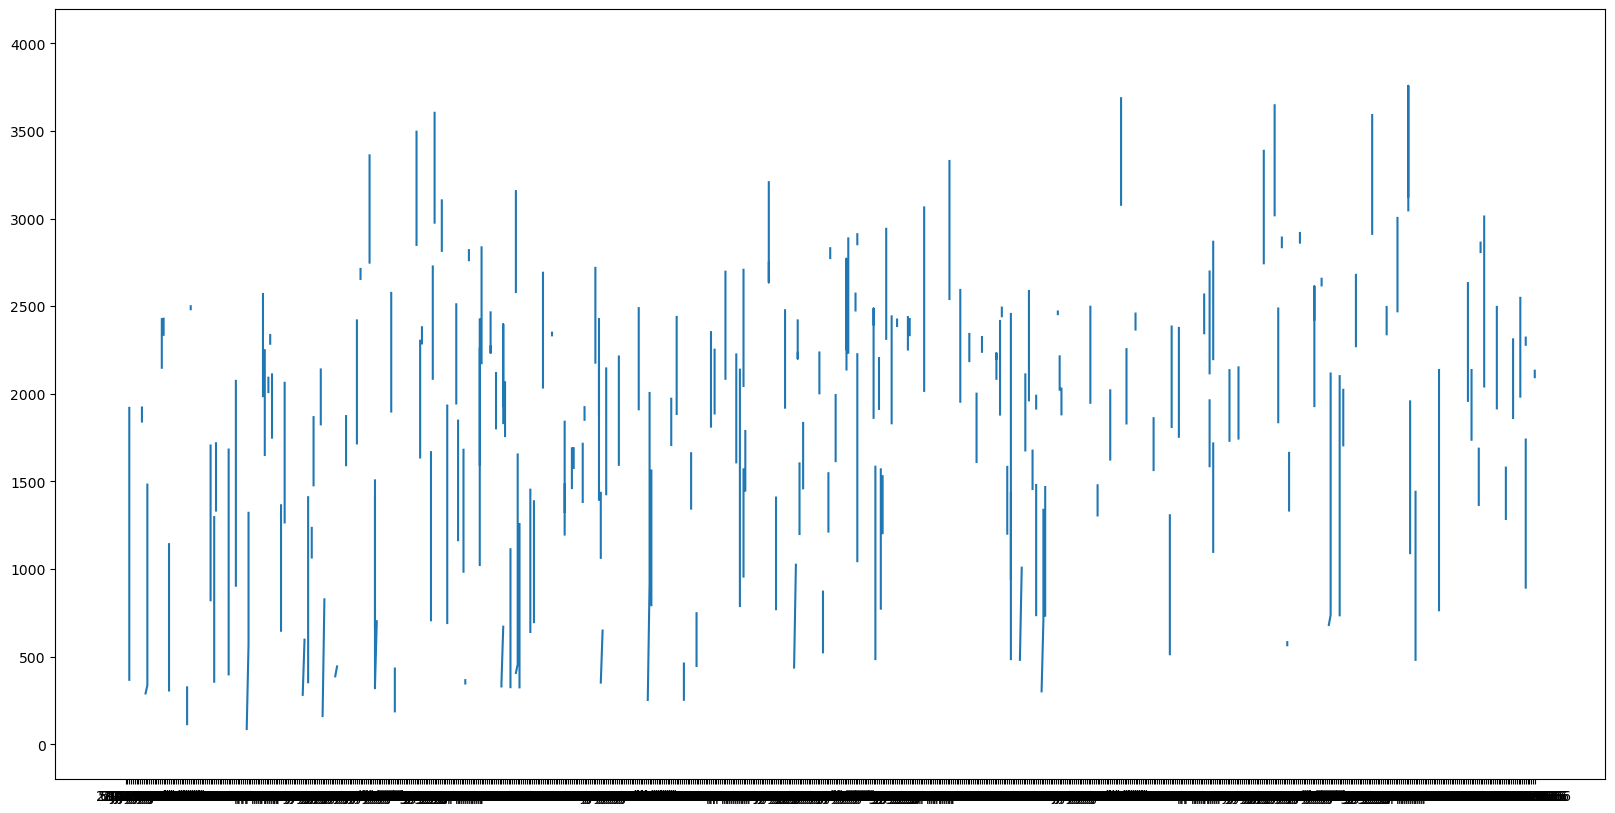

In [3]:
plt.figure(figsize=(20,10))
plt.plot(pos_df['date'], pos_df['units'])
plt.show()

In [4]:
#Convert the date to a date class variable
pos_df['date'] = pd.to_datetime(pos_df['date'], format='%d-%b-%y')

In [5]:
#1. Delete missing values at the hourly level

pos_clean = pos_df.dropna()


#2. Summarize (average or total) values for month within year

#units is the value we want to forecast, we want to total based on these year month combos

pos_month = pos_clean.groupby(['yr', 'mon'])['units'].sum().reset_index()

print(pos_month)



      yr  mon     units
0   2004    1   56392.0
1   2004    2   67539.0
2   2004    3   74179.0
3   2004    4   64487.0
4   2004    5   59831.0
5   2004    6   63307.0
6   2004    7   75686.0
7   2004    8   71213.0
8   2004    9  108364.0
9   2004   10   75827.0
10  2004   11   64584.0
11  2004   12   73883.0
12  2005    1   77678.0
13  2005    2   59612.0
14  2005    3   72775.0
15  2005    4   87209.0
16  2005    5   78497.0
17  2005    6   80838.0
18  2005    7   86890.0
19  2005    8   95887.0
20  2005    9   77283.0
21  2005   10   95623.0
22  2005   11   76608.0
23  2005   12   84623.0
24  2006    1   80727.0
25  2006    2   75889.0
26  2006    3   82199.0
27  2006    4   95301.0
28  2006    5   86293.0
29  2006    6   94229.0
30  2006    7   78498.0
31  2006    8   89776.0
32  2006    9   77024.0
33  2006   10   76604.0
34  2006   11   89900.0
35  2006   12   90453.0


In [6]:
#3. Index the series

pos_month['date'] = pd.to_datetime(pos_month['yr'].astype(str) + '-' + pos_month['mon'].astype(str), format='%Y-%m')
pos_ts = pd.Series(pos_month['units'].values, index=pos_month['date'])
pos_ts.index.freq = 'MS'

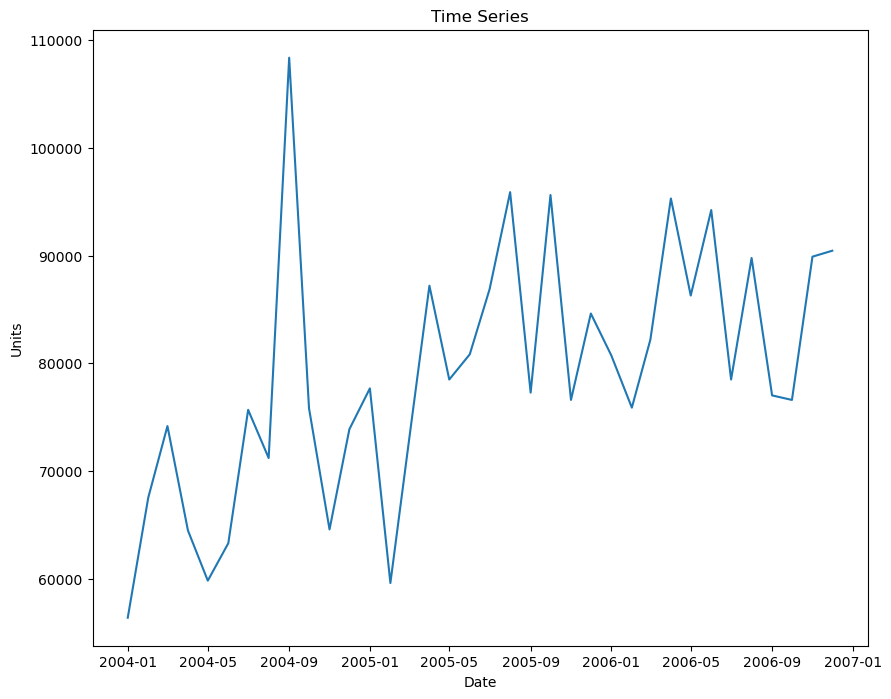

In [7]:
plt.figure(figsize=(10,8))
plt.plot(pos_ts)
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Time Series')
plt.show()

In [8]:
housing_starts_df = pd.read_csv('housing_na.csv')
housing_starts_df

,DATE,HOUST
0,1/1/1990,NaN
1,2/1/1990,1437.0
2,3/1/1990,1289.0
3,4/1/1990,1248.0
4,5/1/1990,1212.0
...,...,...
199,8/1/2006,1650.0
200,9/1/2006,1720.0
201,10/1/2006,1491.0
202,11/1/2006,NaN


Need to fill in these gaps in the dataset

In [9]:
#fillna() or interpolate
housing_starts_df['HOUST'] = housing_starts_df['HOUST'].interpolate(method='linear')
housing_starts_df.columns

Index(['DATE', 'HOUST'], dtype='object')

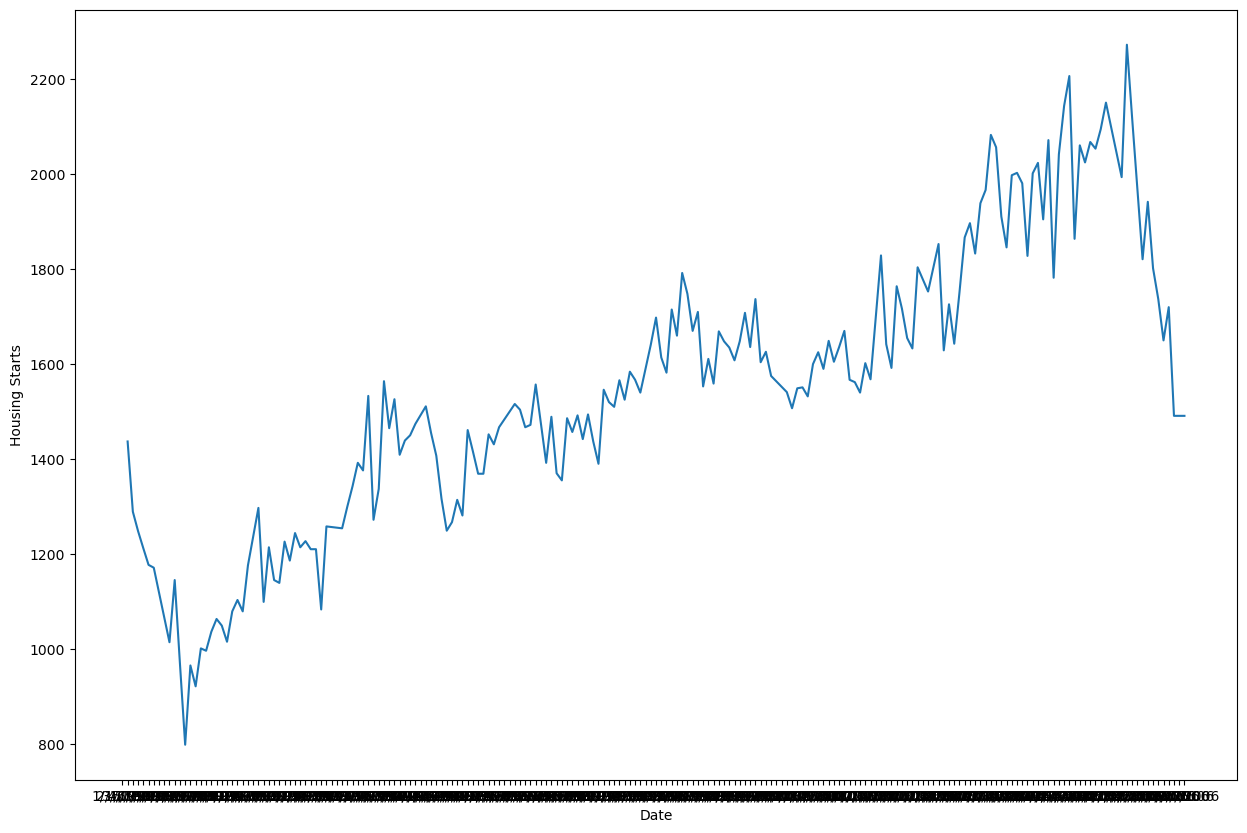

In [10]:
plt.figure(figsize=(15,10))
plt.plot(housing_starts_df['DATE'], housing_starts_df['HOUST'])
plt.xlabel('Date')
plt.ylabel('Housing Starts')
plt.show()

Autocorrelation

In [11]:
solar_df = pd.read_csv('solarpv.csv')
solar_df

,EDT,kW_Gen,Cloud_Cover
0,"Sunday, October 5, 2014",0.553410,4.750000
1,"Sunday, October 12, 2014",0.487093,5.343575
2,"Sunday, October 19, 2014",0.733748,2.285714
3,"Sunday, October 26, 2014",0.531250,4.915071
4,"Sunday, November 2, 2014",0.471055,5.519103
5,"Sunday, November 9, 2014",0.394179,5.722091
6,"Sunday, November 16, 2014",0.329740,5.020809
7,"Sunday, November 23, 2014",0.188297,6.571429
8,"Sunday, November 30, 2014",0.261526,6.028519
9,"Sunday, December 7, 2014",0.320384,4.523284


In [12]:
solar_df['EDT'] = pd.to_datetime(solar_df['EDT'], format='%A, %B %d, %Y')
solar_df.info()
print(solar_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   EDT          42 non-null     datetime64[ns]
 1   kW_Gen       42 non-null     float64       
 2   Cloud_Cover  42 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.1 KB
          EDT    kW_Gen  Cloud_Cover
0  2014-10-05  0.553410     4.750000
1  2014-10-12  0.487093     5.343575
2  2014-10-19  0.733748     2.285714
3  2014-10-26  0.531250     4.915071
4  2014-11-02  0.471055     5.519103
5  2014-11-09  0.394179     5.722091
6  2014-11-16  0.329740     5.020809
7  2014-11-23  0.188297     6.571429
8  2014-11-30  0.261526     6.028519
9  2014-12-07  0.320384     4.523284
10 2014-12-14  0.272520     5.196750
11 2014-12-21  0.231874     6.267935
12 2014-12-28  0.185101     6.400724
13 2015-01-04  0.339067     4.486450
14 2015-01-11  0.258184     6.082209
15

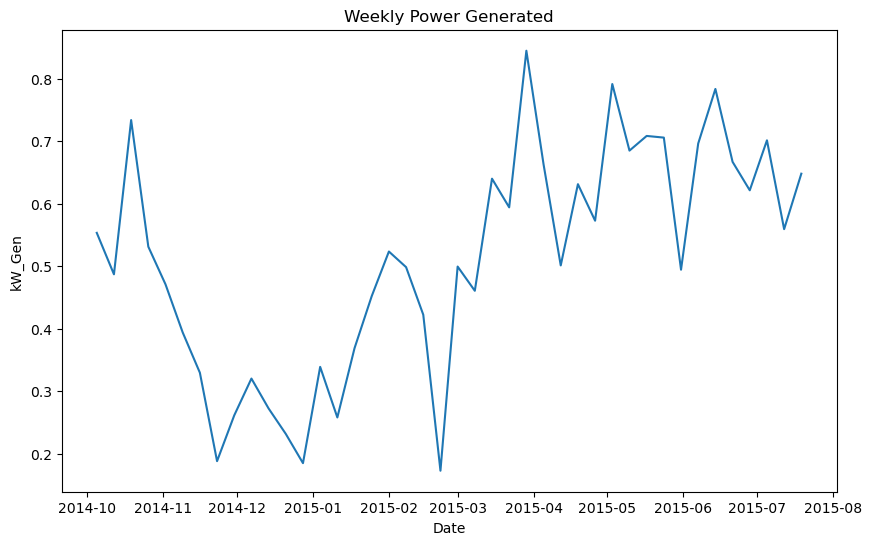

In [13]:
solar_ts = pd.Series(solar_df['kW_Gen'].values, index=solar_df['EDT'])

plt.figure(figsize=(10,6))
plt.plot(solar_ts)
plt.xlabel('Date')
plt.ylabel('kW_Gen')
plt.title('Weekly Power Generated')
plt.show()

In [14]:
kwseries = solar_df['kW_Gen']
sm.stats.acorr_ljungbox(kwseries, lags=[10], return_df=True)
#P-value is less than 0.05 which means that the series is not white noise

,lb_stat,lb_pvalue
10,95.396712,4.527320e-16


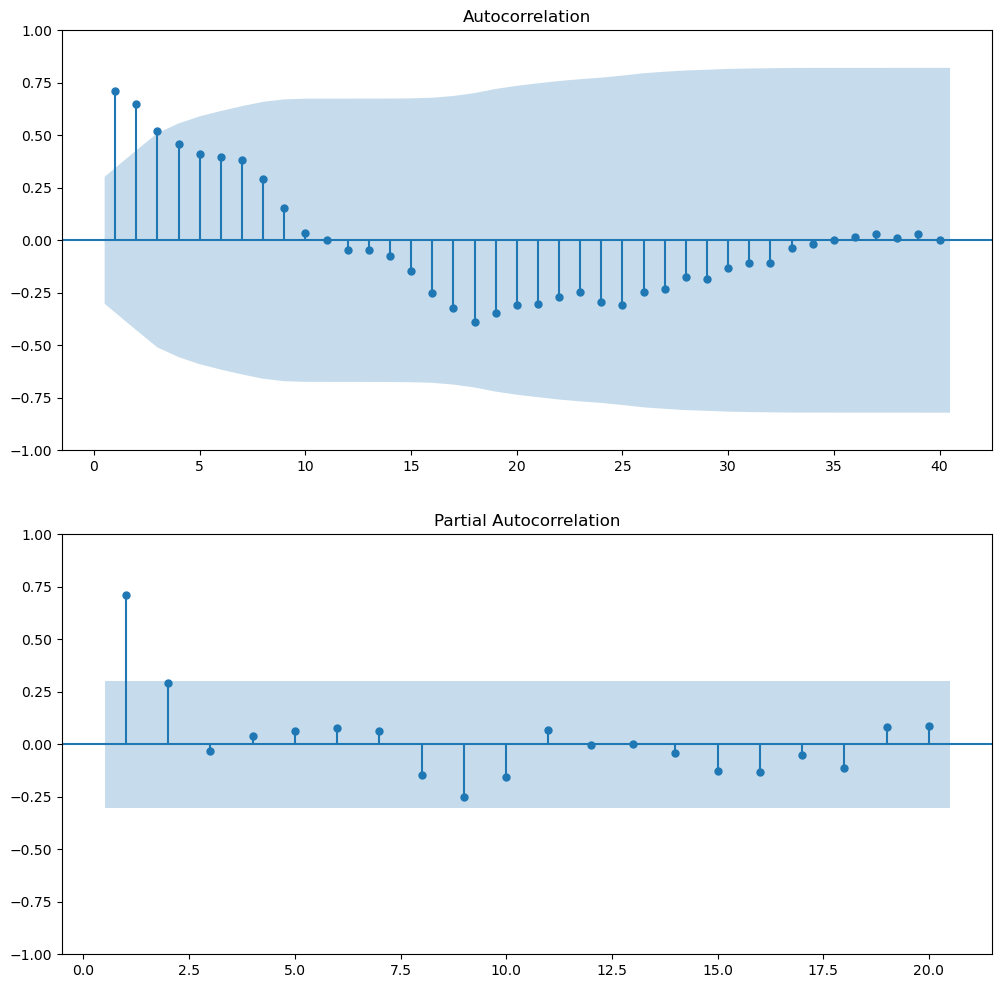

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

#Autocorrelation Plot Using 40 time periods
plot_acf(solar_ts, ax=ax1, zero=False, lags=40)

#Partial autocorrelation plot using 20 time periods
plot_pacf(solar_ts, ax=ax2, zero=False, lags=20)
plt.show()

In [16]:
hotel_df = pd.read_csv('hotel_occ.csv')
hotel_df

,year,month,occupancy,dateval
0,1980,1,276986,7305
1,1980,2,260633,7336
2,1980,3,291551,7365
3,1980,4,275383,7396
4,1980,5,275302,7426
...,...,...,...,...
181,1995,2,473027,12815
182,1995,3,554410,12843
183,1995,4,489574,12874
184,1995,5,462157,12904


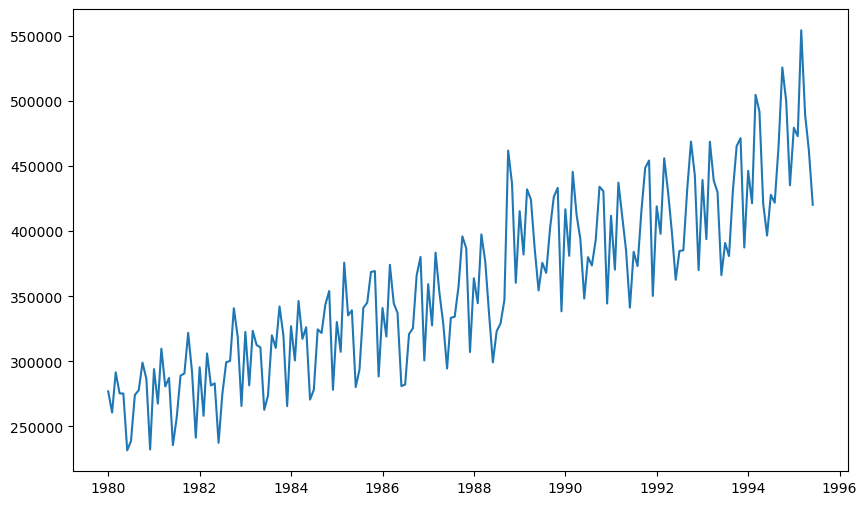

In [17]:
hotel_df['date'] = pd.to_datetime(hotel_df['year'].astype(str) + '-' + hotel_df['month'].astype(str), format='%Y-%m')
hotel_ts = pd.Series(hotel_df['occupancy'].values, index=hotel_df['date'])

#plot the series
plt.figure(figsize=(10,6))
plt.plot(hotel_ts)
plt.show()

In [18]:
#Execute the ljung box test
#P-value is less than 0.05, not white noise
occseries = hotel_df['occupancy']
sm.stats.acorr_ljungbox(occseries, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,869.913315,1.898015e-180


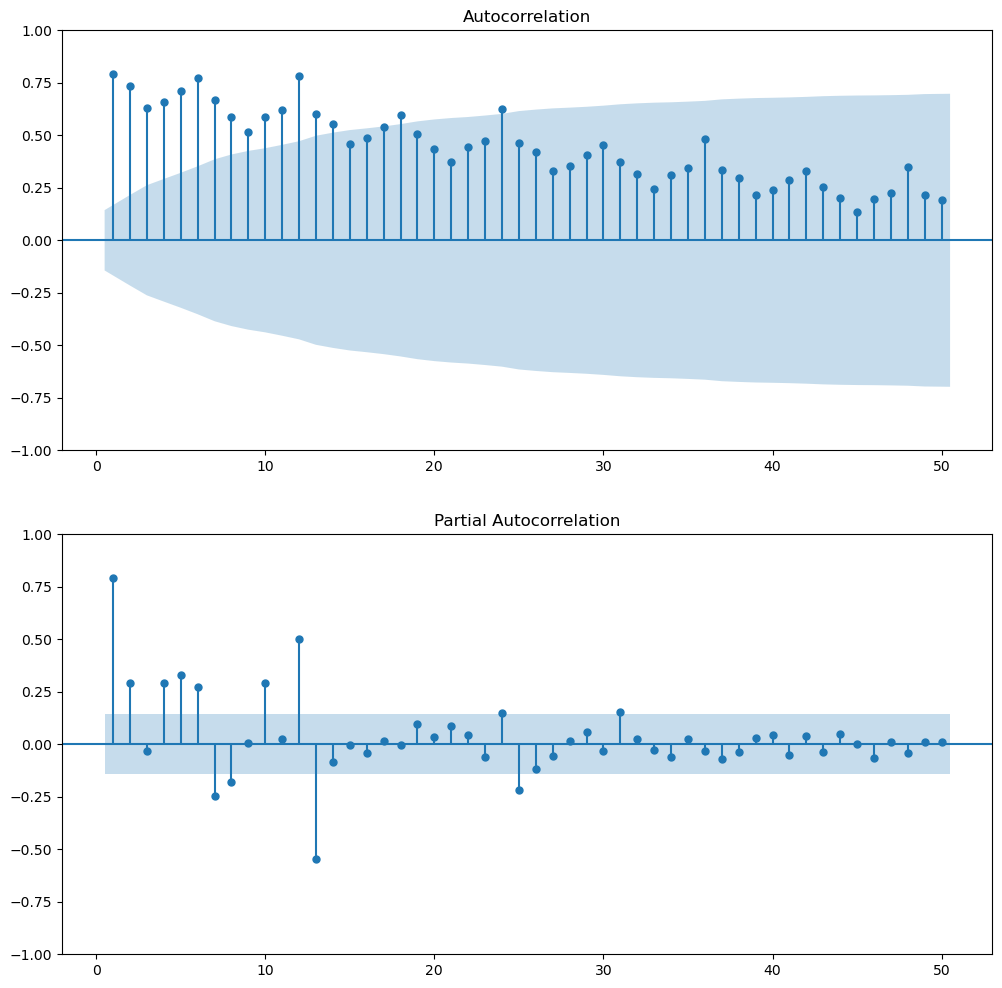

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

#Autocorrelation Plot Using 50 time periods
plot_acf(hotel_ts, ax=ax1, zero=False, lags=50)

#Partial autocorrelation plot using 50 time periods
#This shows a seasonal pattern since there seems to be a cycle
plot_pacf(hotel_ts, ax=ax2, zero=False, lags=50)
plt.show()

In [21]:
#Second number is your p-value if < 0.05, the series is stationary and you do not have to do a single difference.
adfuller(pos_ts, regression='c')

(-2.002408738806859,
 0.28551795090165855,
 7,
 28,
 {'1%': -3.6889256286443146,
  '5%': -2.9719894897959187,
  '10%': -2.6252957653061224},
 525.6455389526648)

       date  sales_diff
1   02/1988    0.846286
2   03/1988    0.591227
3   04/1988    0.349412
4   05/1988    0.474462
5   06/1988    1.141978
..      ...         ...
95  12/1995    0.455573
96  01/1996    1.557850
97  02/1996    1.531856
98  03/1996    3.095163
99  04/1996    4.964348

[99 rows x 2 columns]


Text(0.5, 1.0, 'Sales First Difference')

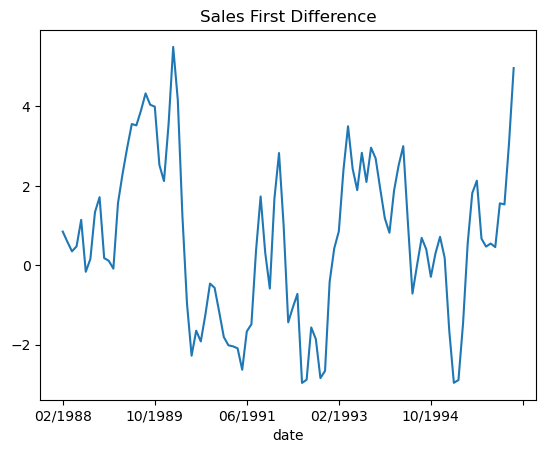

In [31]:
#How to do a single-difference using a different dataset
sales_df = pd.read_csv('sales_series.csv')

sales_df2 = sales_df.drop(index=0)
sales_df2['sales_diff'] = np.diff(sales_df['sales'], n=1)
sales_df2 = sales_df2.drop(columns=['sales'])
print(sales_df2)

sales_ts2 = pd.Series(sales_df2['sales_diff'].values, index=sales_df2['date'])
sales_ts2.index.freq = 'MS'

sales_ts2.plot()
plt.title('Sales First Difference')


In [25]:
#Do we need to remove the trend or do a first difference? First difference since .366 > 0.05
adfuller(hotel_ts, regression='ct')

(-2.424074614734718,
 0.36690023963547636,
 13,
 172,
 {'1%': -4.012391591770221,
  '5%': -3.436329933826581,
  '10%': -3.1422196294037006},
 3763.9403509273543)

Text(0.5, 1.0, 'Detrended Hotel TS')

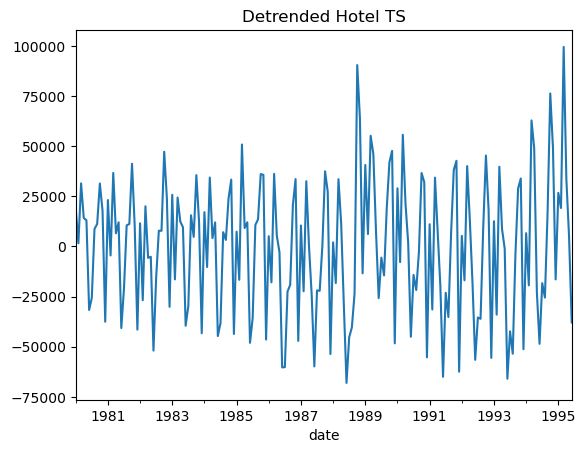

In [30]:
#Detrending the series (even though we need first diff)
hotel_df['detrended_occ'] = detrend(hotel_df['occupancy'], type='linear')
hotel_ts1 = pd.Series(hotel_df['detrended_occ'].values, index=hotel_df['date'])
hotel_ts1.plot()
plt.title('Detrended Hotel TS')